In [1]:
import sys
display(sys.executable)

import ambient_optimizer_python_api as aopa
import numpy as np
import matplotlib.pyplot as plt

display(aopa.version())


'/Users/andrew/Software/personal/ambient/ambient-temperature-estimation/src/apis/python/venv/bin/Python'

2

# Wrapper Test
This notebook generates some data from the C++ model based on some fixed parameters, visualizes it, creates simulated measurements by adding noise, fits that data, and plots the fitted result.

### Define fixed parameters and system state

In [2]:
params = {
    "h": 0.0064168987,
    "q": 0.028977304,
    "T_dev_0": 20,
    "T_amb_0": 30
}

Tamb = np.ones(100) * params['T_amb_0']

In [3]:
def compare_params(truth, result):
    for param in ['h','q', 'T_dev_0', 'T_amb_0']:
        print("{}: truth={}, fitted={}, diff={}".format(param, truth[param], result[param], truth[param] - result[param]))

### Generate and Plot Truth Data

In [4]:
aopa.init({
    "model": "train",
    "verbose": True
})
for ii in range(100):
    aopa.feed(ii, [-1, params['T_amb_0']])

orig_clean_data = aopa.generate(params['h'], params['q'], params['T_dev_0'])
orig_data_T_dev = orig_clean_data['x'][:,0]
orig_data_t = orig_clean_data['t']

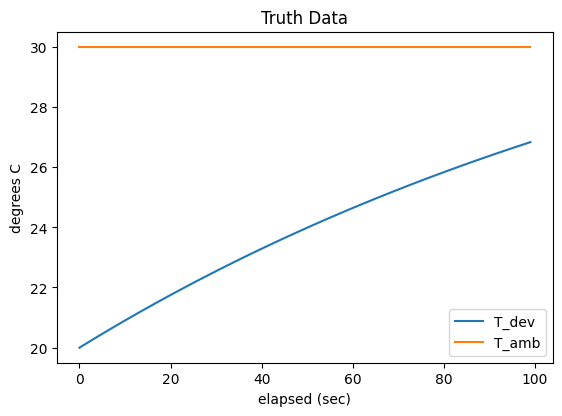

In [5]:
fig = plt.figure()
fig.subplots_adjust(top=0.8)
ax1 = fig.add_subplot(111)
ax1.plot(orig_data_t, orig_data_T_dev, label="T_dev")
ax1.plot(orig_data_t, Tamb, label="T_amb")
ax1.set_title("Truth Data")
ax1.legend()
ax1.set_xlabel("elapsed (sec)")
ax1.set_ylabel("degrees C")
plt.show()

### Create and Plot Simulated Measurements

In [6]:
noise_factor_T_dev = 0.5
noise_factor_T_amb = 0.1
noise_T_dev = np.random.normal(0, noise_factor_T_dev, len(orig_data_T_dev))
measurements_T_dev = orig_data_T_dev + noise_T_dev
noise_T_amb = np.random.normal(0, noise_factor_T_amb, len(Tamb))
measurements_T_amb = Tamb + noise_T_amb

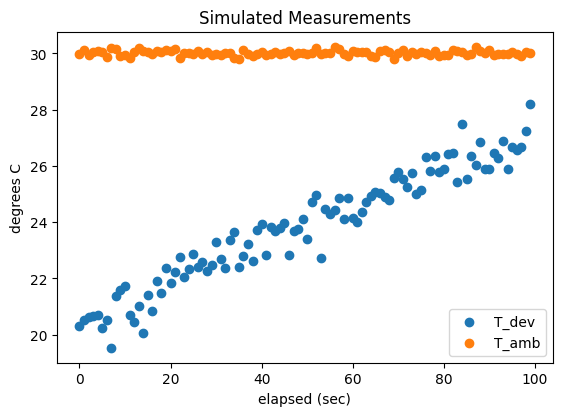

In [7]:
fig = plt.figure()
fig.subplots_adjust(top=0.8)
ax1 = fig.add_subplot(111)
ax1.scatter(orig_clean_data['t'], measurements_T_dev, label="T_dev")
ax1.scatter(orig_clean_data['t'], measurements_T_amb, label="T_amb")
ax1.set_title("Simulated Measurements")
ax1.legend()
ax1.set_xlabel("elapsed (sec)")
ax1.set_ylabel("degrees C")
plt.show()

### Fit the simulated measurements

In [8]:
# feed and fit measurements
aopa.init({
    "model": "train",
    "verbose": True
})
for t, T_dev in enumerate(measurements_T_dev):
    T_amb = measurements_T_amb[t]
    aopa.feed(t, [T_dev, T_amb])

fit_result = aopa.fit()

print(fit_result)

{'is_valid': 1.0, 'rmse': 0.505941928952927, 'icount': 214, 'ifault': 4, 'fitted_params': {'h': 0.004686292881292586, 'q': 0.03938103030707259, 'T_dev_0': 20.209870848559767, 'T_amb_0': 0.0}}


In [9]:
compare_params(params, fit_result['fitted_params'])

h: truth=0.0064168987, fitted=0.004686292881292586, diff=0.001730605818707414
q: truth=0.028977304, fitted=0.03938103030707259, diff=-0.010403726307072588
T_dev_0: truth=20, fitted=20.209870848559767, diff=-0.2098708485597669
T_amb_0: truth=30, fitted=0.0, diff=30.0


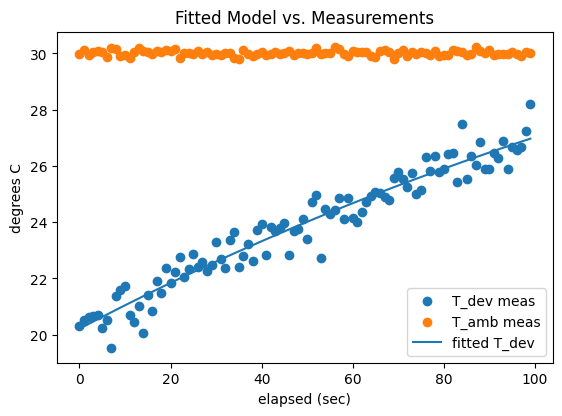

In [10]:
fitted_params = fit_result['fitted_params']
aopa.init({
    "model": "train",
    "verbose": True
})
for t, T_dev in enumerate(measurements_T_dev):
    T_amb = measurements_T_amb[t]
    aopa.feed(t, [-1, T_amb])
fitted_data = aopa.generate(fitted_params['h'], fitted_params['q'], fitted_params['T_dev_0'])

fitted_Tdev = fitted_data['x'][:,0]

fig = plt.figure()
fig.subplots_adjust(top=0.8)
ax1 = fig.add_subplot(111)
ax1.scatter(fitted_data['t'], measurements_T_dev, label="T_dev meas")
ax1.scatter(fitted_data['t'], measurements_T_amb, label="T_amb meas")
ax1.plot(fitted_data['t'], fitted_Tdev, label="fitted T_dev")
ax1.set_title("Fitted Model vs. Measurements")
ax1.legend()
ax1.set_xlabel("elapsed (sec)")
ax1.set_ylabel("degrees C")
plt.show()